In [19]:
import tensorflow as tf
import os
import cv2
import imghdr

In [20]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [21]:
tf.config.list_physical_devices('GPU')

[]

In [97]:
import os
import imghdr
from PIL import Image
import tensorflow as tf

image_exts = ['jpeg', 'jpg']
train_dir = "train"

def remove_corrupted_images(data_dir):
    if not os.path.isdir(data_dir):
        print(f"Provided path {data_dir} is not a directory")
        return
    
    for image_class in os.listdir(data_dir):
        class_path = os.path.join(data_dir, image_class)
        if not os.path.isdir(class_path):
            continue
        
        for image in os.listdir(class_path):
            image_path = os.path.join(class_path, image)
            if imghdr.what(image_path) not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
                continue
            
            # Check if the image can be loaded with PIL and decoded with TensorFlow
            if not is_image_valid(image_path):
                print(f'Removing corrupted or undecodable image {image_path}')
                os.remove(image_path)

def is_image_valid(filename):
    try:
        # Use PIL to verify the image
        with Image.open(filename) as img:
            img.verify()
        
        # Use TensorFlow to decode the image
        image_string = tf.io.read_file(filename)
        tf.image.decode_jpeg(image_string, channels=3)  # This will throw an error if the image cannot be decoded
        return True
    except (IOError, tf.errors.InvalidArgumentError):
        return False


In [98]:
remove_corrupted_images(train_dir)

Removing corrupted or undecodable image train\nowildfire\-114.152378,51.027198.jpg


In [99]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [100]:
data = tf.keras.utils.image_dataset_from_directory('train')

Found 30249 files belonging to 2 classes.


In [101]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

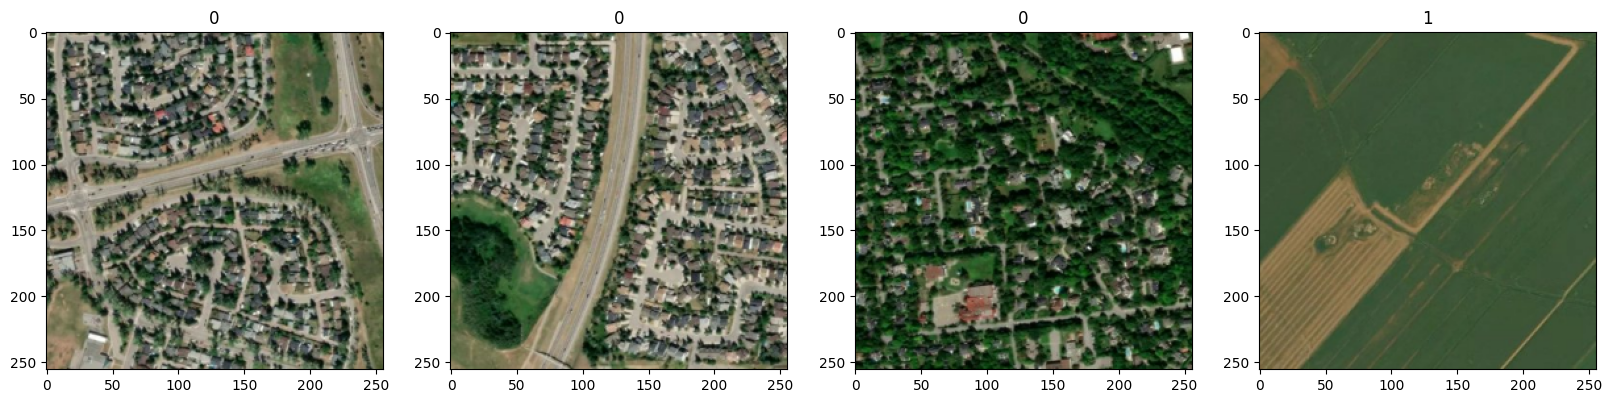

In [102]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [103]:

data.as_numpy_iterator().next()

(array([[[[ 37.250565 ,  71.250565 ,  34.250565 ],
          [ 39.38539  ,  73.38539  ,  36.38539  ],
          [ 34.08815  ,  68.08815  ,  31.08815  ],
          ...,
          [ 26.213715 ,  69.04518  ,  23.045181 ],
          [ 27.449219 ,  70.44922  ,  24.898438 ],
          [ 29.517075 ,  72.517075 ,  27.517075 ]],
 
         [[ 33.63414  ,  67.63414  ,  30.63414  ],
          [ 38.494843 ,  72.49484  ,  35.494843 ],
          [ 32.565887 ,  66.56589  ,  29.565887 ],
          ...,
          [ 31.064713 ,  72.55078  ,  27.652344 ],
          [ 33.562424 ,  75.46086  ,  30.764221 ],
          [ 34.037735 ,  75.93617  ,  31.486954 ]],
 
         [[ 39.062454 ,  73.062454 ,  36.062454 ],
          [ 35.05963  ,  69.05963  ,  32.05963  ],
          [ 31.27301  ,  65.27301  ,  28.27301  ],
          ...,
          [ 43.891937 ,  83.206604 ,  39.206604 ],
          [ 39.90352  ,  80.90352  ,  36.90352  ],
          [ 35.52066  ,  76.52066  ,  32.52066  ]],
 
         ...,
 
         [[ 

In [105]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [106]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [108]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [109]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [110]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 16)       

In [111]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
662/662 [==============================] - 374s 564ms/step - loss: 1.8498 - accuracy: 0.8398 - val_loss: 0.3991 - val_accuracy: 0.8295
Epoch 2/20
662/662 [==============================] - 364s 550ms/step - loss: 0.2694 - accuracy: 0.8986 - val_loss: 0.2907 - val_accuracy: 0.8894
Epoch 3/20
662/662 [==============================] - 365s 551ms/step - loss: 0.2450 - accuracy: 0.9094 - val_loss: 0.2704 - val_accuracy: 0.9034
Epoch 4/20
662/662 [==============================] - 370s 559ms/step - loss: 0.2016 - accuracy: 0.9274 - val_loss: 0.2903 - val_accuracy: 0.9034
Epoch 5/20
662/662 [==============================] - 374s 565ms/step - loss: 0.1616 - accuracy: 0.9445 - val_loss: 0.3213 - val_accuracy: 0.9008
Epoch 6/20
662/662 [==============================] - 379s 572ms/step - loss: 0.1529 - accuracy: 0.9485 - val_loss: 0.3606 - val_accuracy: 0.8967
Epoch 7/20
662/662 [==============================] - 366s 553ms/step - loss: 0.1193 - accuracy: 0.9618 - val_loss: 0.5123 -

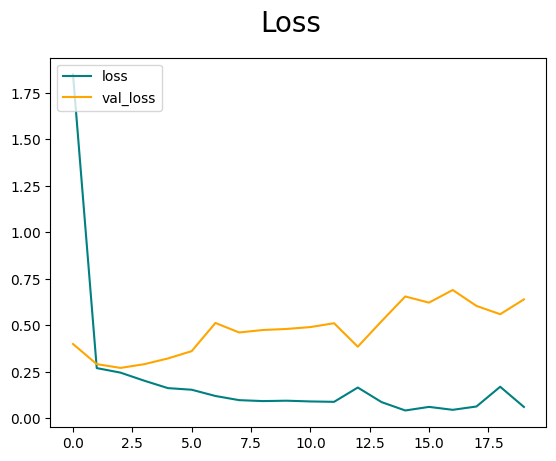

In [112]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

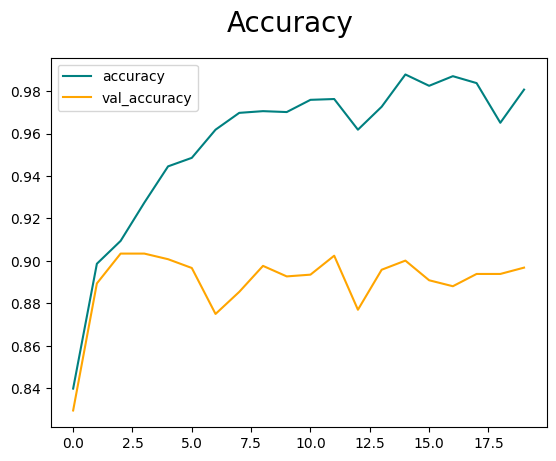

In [113]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [114]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()


In [115]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [116]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 0s 93ms/step
tf.Tensor(0.87652814, shape=(), dtype=float32) tf.Tensor(0.9151244, shape=(), dtype=float32) tf.Tensor(0.88863033, shape=(), dtype=float32)


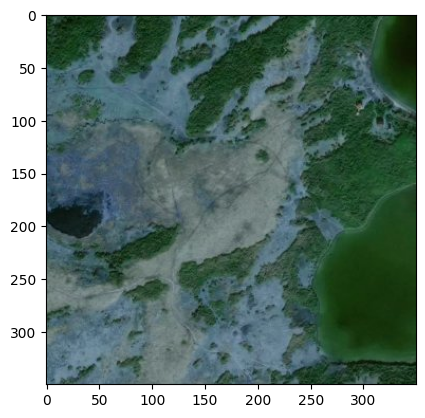

In [152]:
import cv2
img = cv2.imread('train/nowildfire/-73.7498,45.435485.jpg')
plt.imshow(img)

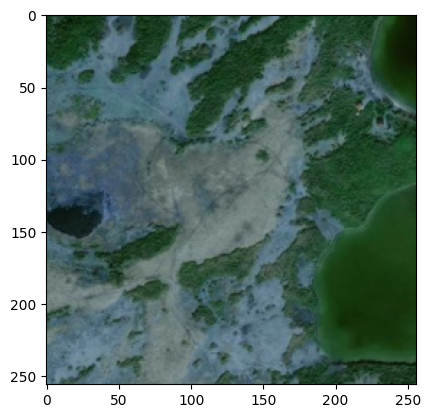

In [153]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [157]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 21ms/step


array([[0.9368669]], dtype=float32)

In [134]:
from tensorflow.keras.models import load_model
model.save("wildfire.h5")
new_model = load_model('wildfire.h5')
new_model.predict(np.expand_dims(resize/255, 0))



c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 58ms/step


array([[0.93795687]], dtype=float32)